# Evaluation and analysis of results

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import textwrap

In [17]:
# load data
question_data = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/questions_overview_answerFromTable.xlsx")
results_b1 = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/predictions/preds_answerFromTable_b1.xlsx")
results_b2 = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/predictions/preds_answerFromTable_b2.xlsx")
results_mcot = pd.read_excel("/home/maria/STUDIUM/Master/5.Semester/Seminar/llmSeminar/data/predictions/preds_answerFromTable_mcot.xlsx")


In [18]:
# concat evaluation of results to metadata df
results_df = pd.concat([question_data, pd.Series(list(results_b1["correct"]), name='correct_b1'), pd.Series(list(results_b2["correct"]), name='correct_b2'), pd.Series(list(results_mcot["correct"]), name='correct_mcot')], axis=1)

In [19]:
results_b1["design"] = "Baseline 1"
results_b2["design"] = "Baseline 2"
results_mcot["design"] = "Manual CoT"
results_df_long = pd.concat([results_b1, results_b2, results_mcot])
results_df_long.columns

Index(['question_uid', 'gptAnswer', 'extractedAnswer', 'label', 'correct',
       'problem', 'note', 'scale', 'derivation', 'design'],
      dtype='object')

In [20]:
results_df = pd.merge(results_df_long, question_data, on='question_uid', how='outer')

In [21]:
# percentage of correct/false answers

print(results_df.groupby(["design"])["correct"].value_counts(normalize=True))


design      correct
Baseline 1  True       0.56
            False      0.44
Baseline 2  True       0.65
            False      0.35
Manual CoT  True       0.63
            False      0.37
Name: proportion, dtype: float64


<Axes: xlabel='design'>

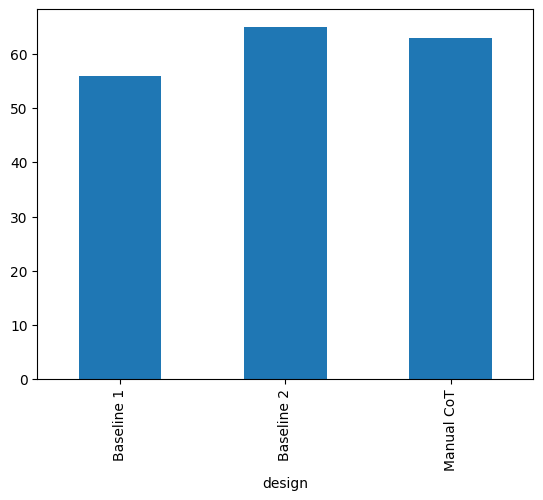

In [22]:
results_df[results_df.correct == True].groupby(['design']).size().plot(kind = "bar")

In [23]:
# reorder levels of question category (-> define order to be shown in plot)
question_categories = ["span (no comparison)", "span (requires comparison)", "Multi-span", "count", "total", "difference", "ratio", "percentage of", "percentage change", "average"]
results_df["category_finegrained"] = pd.Categorical(results_df["category_finegrained"], categories = question_categories)


In [24]:
# percentage of correct answers / category
grouped_df = results_df.groupby(["category_finegrained", 'design'])['correct'].mean() * 100


/tmp/ipykernel_73447/728842839.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = results_df.groupby(["category_finegrained", 'design'])['correct'].mean() * 100


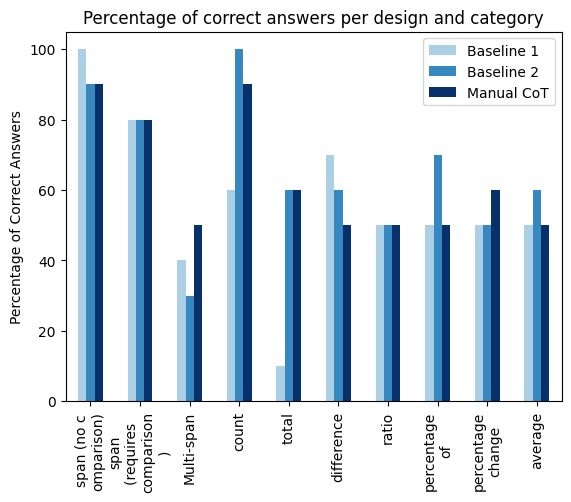

In [32]:
unique_values_cat = results_df['design'].unique()

# Create a color map for each unique value in column A
color_dict = {value: plt.cm.Blues_r((len(unique_values_cat) - i - 1) / len(unique_values_cat)) for i, value in enumerate(unique_values_cat)}

# Map the colors to the groups in column A
grouped_df_colors = results_df['design'].map(color_dict)


# Plot the bar chart with different colors for each unique value in column A
ax = grouped_df.unstack('design').plot(kind='bar', ylabel='Percentage of Correct Answers',
                             title='Percentage of correct answers per design and category', color=grouped_df_colors)


ax.legend(title='', loc='upper right')  # Hide legend title

labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)



ax.set_xlabel('')  # Hide x-axis label
# Show the plot
plt.show()

In [37]:
# by table size

for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["table_small"])[i].value_counts(normalize=True))
    print("\n")


table_small  correct_b1
False        False         0.54
             True          0.46
True         True          0.66
             False         0.34
Name: proportion, dtype: float64


table_small  correct_b2
False        True          0.6
             False         0.4
True         True          0.7
             False         0.3
Name: proportion, dtype: float64


table_small  correct_mcot
False        True            0.54
             False           0.46
True         True            0.72
             False           0.28
Name: proportion, dtype: float64




In [38]:
# by category


for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["category"])[i].value_counts(normalize=True))
    print("\n")



category                    correct_b1
Multi-span                  False         0.600000
                            True          0.400000
arithmetic                  False         0.533333
                            True          0.466667
count                       True          0.600000
                            False         0.400000
span (no comparison)        True          1.000000
span (requires comparison)  True          0.800000
                            False         0.200000
Name: proportion, dtype: float64


category                    correct_b2
Multi-span                  False         0.700000
                            True          0.300000
arithmetic                  True          0.583333
                            False         0.416667
count                       True          1.000000
span (no comparison)        True          0.900000
                            False         0.100000
span (requires comparison)  True          0.800000
                    

In [39]:
# by category (finegrained)
for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["category", "category_finegrained"])[i].value_counts(normalize=True))
    print("\n")


category                    category_finegrained        correct_b1
Multi-span                  Multi-span                  False         0.6
                                                        True          0.4
arithmetic                  average                     True          0.5
                                                        False         0.5
                            difference                  True          0.7
                                                        False         0.3
                            percentage change           False         0.5
                                                        True          0.5
                            percentage of               False         0.5
                                                        True          0.5
                            ratio                       False         0.5
                                                        True          0.5
                            total            

In [40]:
# by table size & category

for i in ["correct_b1", "correct_b2", "correct_mcot"]:
    print(results_df.groupby(["category", "table_small"])[i].value_counts(normalize=True))
    print("\n")


category                    table_small  correct_b1
Multi-span                  False        False         0.600000
                                         True          0.400000
                            True         False         0.600000
                                         True          0.400000
arithmetic                  False        False         0.666667
                                         True          0.333333
                            True         True          0.600000
                                         False         0.400000
count                       False        True          0.600000
                                         False         0.400000
                            True         True          0.600000
                                         False         0.400000
span (no comparison)        False        True          1.000000
                            True         True          1.000000
span (requires comparison)  False        True       